# BOIP Figures

## Table of Contents
- [Functions](#functions)
- [Michalewicz figure](#michalewicz-figure)
- [Regret/Surface plots](#regret-and-surface-plots)
- [False hit pruning / Uncertainty (in/de)flation plots](#gamma-sweep)
- [Design space pruning](#design-space-pruning)

In [1]:
import colorsys
from pathlib import Path
import string
from typing import Optional, Tuple

from botorch.test_functions.base import BaseTestProblem
from matplotlib import pyplot as plt, patheffects as pe
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy import stats
import seaborn as sns
import torch
from torch import Tensor

import boip

sns.set_theme("talk", "white")

## Functions

[back to top](#table-of-contents)

the functions used in this notebook are all defined below. They are roughly organized according to their end usage. All of these cells must be run before any plotting can occur!

### Discrete surface plotting

In [2]:
def plot_surface_discrete(
    ax,
    choices: np.ndarray,
    y: np.ndarray,
    zmin: float,
    zmax: float,
    hits: np.ndarray,
    title: Optional[str] = None,
):
    """plot the discretized objective

    Parameters
    ----------
    ax
        the axis onto which the level surface should be plotted
    choices : np.ndarray
        an iterable of `n x d` array corresponding to the design space
    y : np.ndarray
        a vector parallel to choices that contains the y-value for corresponding to each point 
        point in the design space 
    hits: np.ndarray
    title : Optional[str], default=None
        the title to use for the plot

    Returns
    -------
    ax
        the axis on which the surface was plotted
    """
    sc = ax.scatter(
        choices[:, 0], choices[:, 1], c=y, vmin=zmin, vmax=zmax,
        s=10, cmap="coolwarm", alpha=0.7, zorder=0
    )
    ax.plot(hits[:, 0], hits[:, 1], "y*", ms=12, mec="black", zorder=2)

    ax.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )

    buffer = 0.02
    ax.text(
        buffer, 1-buffer, title,
        color="w", ha="left", va="top", transform=ax.transAxes,
    ).set_path_effects([pe.withStroke(linewidth=5, foreground="k")])
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    return sc
    
def prune(choices: np.ndarray, H: np.ndarray, i: int) -> np.ndarray:
    mask = np.ones(len(choices), bool)
    mask[(0 <= H) & (H <= i)] = False

    return mask

def plot_acquired_points(ax, X, Y, zmin, zmax):
    return ax.scatter(
        X[:,0], X[:,1], s=20, c=Y, vmin=zmin, vmax=zmax,
        cmap="coolwarm", edgecolor='k', linewidth=2, zorder=1, alpha=0.7
    )

### Regret / Size curves

In [3]:
def immediate_regret(Y: np.ndarray, optima: np.ndarray) -> np.ndarray:
    """calculate the immediate top-k regret for the observed values given the objective top-k
    optima

    Parameters
    ----------
    Y : np.ndarray
        an `r x t` array, where r is the number of repeats and t is the number of observations made
        for a given trial. Each entry is the observation made at iteration t
    optima : np.ndarray
        a length `k` vector containing the optima of the objective function

    Returns
    -------
    np.ndarray
        an `r x t` array containing the immediate regret at the given iteration, where r is number of repititions and t is number of iterations. "Immediate regret" is formulated as the
        fraction of the total number of optima found. NOTE: it is possible for there to be
        degenerate hits
    """
    k = len(optima)
    Y = np.nan_to_num(Y, nan=-np.inf)
    t = optima.min()
    Y_star = np.empty(Y.shape)
    
    for i in range(k, Y.shape[1]):
        Y_star[:,i] = (np.partition(Y[:,:i+1], -k, 1)[:, -k:] >= t).sum(1)
        
    return Y_star / len(optima)

def scale_lightness(rgb: Tuple, scale: float):
    h, l, s = colorsys.rgb_to_hls(*rgb)

    return colorsys.hls_to_rgb(h, min(1, l * scale), s)

def add_regret_trace(ax, R: np.ndarray, x, label: str):
    r = R.mean(0)
    r_se = stats.sem(R, 0)
    
    # r_max = np.max(R, 0)
    # r_min = np.min(R, 0)
    # r_q1 = np.quantile(R, 0.25, 0)
    # r_q3 = np.quantile(R, 0.75, 0)

    # r = np.median(R, 0)
    # r_max = np.max(R, 0)
    # r_min = np.min(R, 0)
    # r_q1 = np.quantile(R, 0.25, 0)
    # r_q3 = np.quantile(R, 0.75, 0)

    handle = ax.plot(
        x,
        r,
        label=label,
        lw=5,
        path_effects=[pe.Stroke(linewidth=7.5, foreground="k"), pe.Normal()],
    )
    # handles.append(handle)
    c = handle[0].get_color()

    # ax.plot(x, r_q3, color=c, lw=3.5, alpha=0.7)
    # ax.plot(x, r_q1, color=c, lw=3.5, alpha=0.7)
    # ax.plot(x, r_max, color=c, lw=2, ls=":", alpha=0.5)
    # ax.plot(x, r_min, color=c, lw=2, ls=":", alpha=0.5)

    # ax.fill_between(x, r_q1, r_q3, alpha=0.5, lw=2.0, color=c, ec="black")
    # ax.fill_between(x, r_min, r_max, alpha=0.3, dashes=":", lw=2.0, color=c, ec="black")
    ax.fill_between(x, r-r_se, r+r_se, alpha=0.5, lw=2.0, color=c, dashes=":", ec="black")

    return handle

def plot_IR(
    ax,
    Y_full: np.ndarray,
    Y_prune: np.ndarray,
    N: int,
    optima: np.ndarray,
    obj,
    choices,
):
    """plot the immediate regret curves of the dataset onto axis ax

    Parameters
    ----------
    ax
        the axis on which to plot the curves
    Ys : Iterable[np.ndarray]
        an iterable of `r x t` arrays, where each entry is the observation made at
        iteration t of trial r for a specific dataset
    obj : BaseTestProblem
        the objective these datasets are attempting to minimize
    N : int
        the number of initial random observations
    labels : Optional[Iterable[str]]
        the label of each trace
    optima : np.ndarray
        the optimal objective values

    Returns
    -------
    List
        the artists corresponding to the plotted curves
    """   
    handles = [] 
    x = np.arange(Y_prune.shape[1])[N:]

    R = immediate_regret(Y_full, optima)[:, N : N + len(x)]
    handles.append(add_regret_trace(ax, R, x, "no pruning"))

    R = immediate_regret(Y_prune, optima)[:, N:]
    handles.append(add_regret_trace(ax, R, x, "pruning"))

    R = gen_R_random(obj, *Y_prune.shape, optima, choices)[:, N:]
    r = R.mean(0)
    r_se = stats.sem(R, 0)
    
    handles.append(ax.plot(
        x,
        r,
        c="grey",
        label="random",
        lw=5,
        path_effects=[pe.Stroke(linewidth=7.5, foreground="k"), pe.Normal()],
    ))
    ax.fill_between(x, r-r_se, r+r_se, color="grey", alpha=0.7, dashes=":", lw=2.0, ec="black")

    return [h[0] for h in handles]

def gen_R_random(
    obj,
    r: int,
    n: int,
    optima: Tensor,
    choices: Tensor,
):
    """add a trace for random acquisition

    Parameters
    ----------
    obj
        the objective to generate the trace for
    r : int
        the number of repeats
    n : int
        the number of samples to take

    Returns
    -------
    np.ndarray
        the immediate regret matrix for random acquisition
    """
    idxs = torch.empty((r, n)).long()
    for i in range(r):
        idxs[i] = torch.randperm(len(choices))[:n]

    X = choices[idxs]
    Y = obj(X).numpy()

    return immediate_regret(Y, optima)

def plot_surface(
    ax,
    obj: BaseTestProblem,
    optimal_choices: np.ndarray,
    title: Optional[str] = None,
):
    """plot the level surface of the given objective onto the specified axis

    Parameters
    ----------
    ax
        the axis onto which the level surface should be plotted
    obj : BaseTestProblem
        the objective to which the level surface corresponds
    Xs : Iterable[np.ndarray]
        an iterable of `r x t x d` arrays. Where each entry in each array corresponds to the
        d-dimensional point acquired at iteration t of trial r
    optimal_choices: np.ndarray
    title : Optional[str], default=None
        the title to use for the plot. If None, use the name of the objective function

    Returns
    -------
    ax
        the axis on which the surface was plotted
    """
    X1_bounds, X2_bounds = zip(*obj.bounds.numpy())
    x1 = np.linspace(*X1_bounds, 100)
    x2 = np.linspace(*X2_bounds, 100)

    X1, X2 = np.meshgrid(x1, x2)
    Z = -obj(torch.from_numpy(np.stack((X1, X2), axis=2))).numpy()

    cs1 = ax.contourf(X1, X2, Z, 8, cmap="coolwarm", zorder=0, alpha=0.7)
    ax.contour(X1, X2, Z, cs1.levels, colors='k', alpha=0.5, linestyles='solid')

    ax.plot(optimal_choices[:, 0], optimal_choices[:, 1], "y*", ms=12, mec="black", zorder=2)

    ax.set_title(title if title is not None else str(obj)[:-2], size="large")
    ax.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )

    return ax

def plot_size_H(ax, H, q: int, T: int):
    """plot the input space size using the pruning history

    Parameters
    ----------
    ax
        the axis on which to plot
    H : np.ndarray
        an `r x n x 2` array containing the acquisition and pruning history of each point, where r 
        is the number of repeats and n is the total input space size. The 0th value of each entry is the iteration at
        which the given point was pruned from the input space, with a -1 indicating that the
        point was never pruned
    q : int
        the batch/initialization size
    T : int
        the number of optimzation iterations

    Returns
    -------
    handle
        the matplotlib artist corresponding to the plotted curve
    """
    N = H.shape[1]
    N_prune_t = np.empty((len(H), T+1), int)
    for t in range(N_prune_t.shape[1]):
        N_prune_t[:, t] = (H == t).sum(2).sum(1)

    S = N - np.cumsum(N_prune_t, 1)
    x = q * (1+np.arange(S.shape[1]))
    
    S = S/S[0, 0]
    s = S.mean(0)
    s_se = stats.sem(S, 0)

    handle = ax.plot(
        x,
        s,
        'g--',
        lw=2.5,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()],
        label="size",
    )[0]
    ax.fill_between(x, s-s_se, s+s_se, color='g', alpha=0.3, lw=2.0)
    
    return handle

### False hit pruning

In [4]:
def f_hits_pruned(H, hit_idxs, T):
    hits_pruned_t = np.zeros((len(H), T+1))
    for t in range(hits_pruned_t.shape[1]):
        hits_pruned_t[:, t] = (H[:, hit_idxs] == t).sum(1)

    return np.cumsum(hits_pruned_t, 1) / len(hit_idxs)
    
def calc_FNR(P_fn: float, acq_rate: float, T: int) -> np.ndarray:
    """calculate the false negative rate for the given iteration
    
    Parameters
    ----------
    P_fn : float
        the probability of a false negative
    acq_rate : float
        the fraction of remaining positives that are acquired at each iteration
    T : int
        the total number of iterations
    
    Returns
    -------
    FNR : np.ndarray
        a vector of length `T` containing the false negative rate at each iteration
    """
    F_hits = ((1-P_fn) * (1-acq_rate))**np.arange(T)
    return P_fn * np.cumsum(F_hits)
    

In [5]:
def plot_IR_all(
    ax,
    x: np.ndarray,
    Y: np.ndarray,
    N: int,
    optima: np.ndarray,
    color,
    label: str
):
    """plot the immediate regret curves of the dataset onto axis ax

    Parameters
    ----------
    ax
        the axis on which to plot the curves
    x : np.ndarray
        a vector of the x-value for each regret trace
    Y : np.ndarray
        an iterable of `r x t` array, where each entry is the observation made at
        iteration t of trial r for a specific dataset
    N : int
        the number of initial random observations
    optima : np.ndarray
        the optimal objective values
    label : str
        the label of the traces

    Returns
    -------
    List
        the artists corresponding to the plotted curves
    """   
    handles = [] 

    R = immediate_regret(Y, optima)[:, N : N + len(x)]
    r = np.median(R, 0)
    handles = ax.plot(
        x,
        r,
        color=color,
        lw=5,
        path_effects=[pe.Stroke(linewidth=7.5, foreground="k"), pe.Normal()],
        label=label,
        zorder=10
    )
    c = handles[0].get_color()

    for r in R:
        ax.plot(x, r, color=c, lw=3, alpha=0.2)

    return handles[0]

## Michalewicz figure

[back to top](#table-of-contents)

This is the test function figure from the main text and it is composed of three separate parts. You must run each of the cells below in order for the figure to be formatted properly!

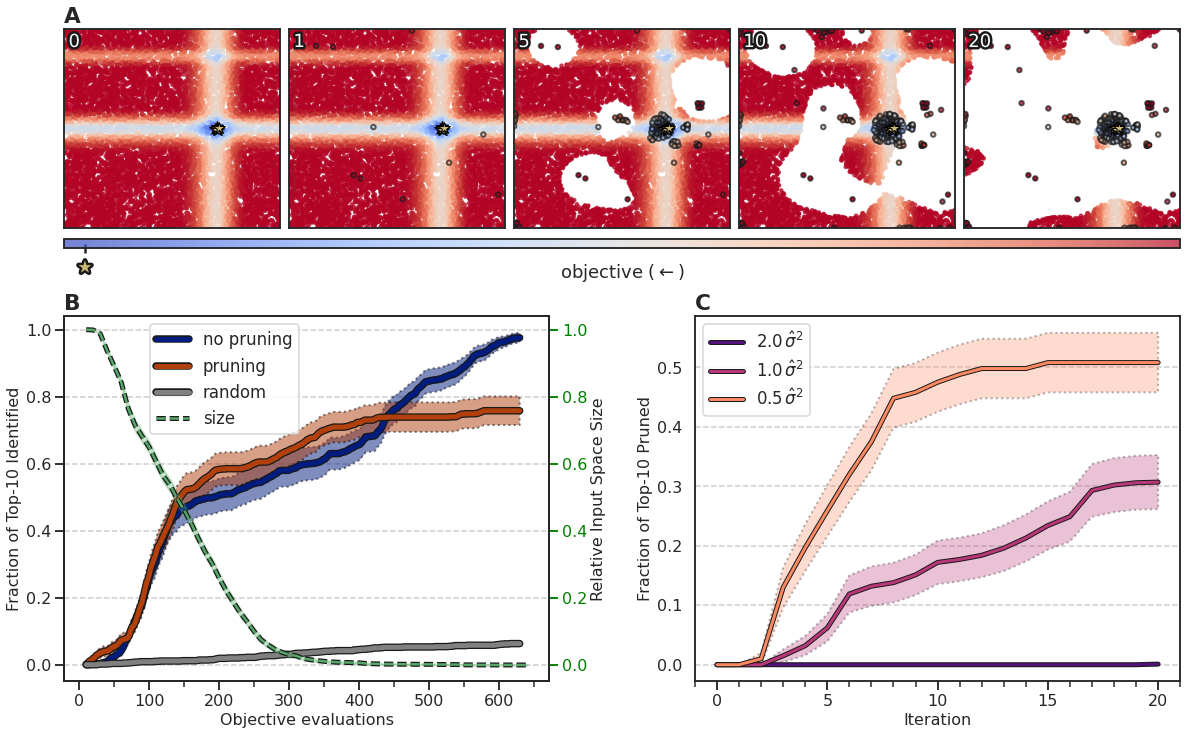

In [115]:
fig = plt.figure(figsize=(5*4, 3*4), constrained_layout=False)

gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.65], hspace=0.225)

gs0 = gs[0].subgridspec(1, 5, wspace=0.04,)
gs1 = gs[1].subgridspec(1, 2, wspace=0.3,)

#---------------------------------------- PANEL A ----------------------------------------#

npzdir = Path('/home/degraff/active-projects/boip/runs/all-objs/michalewicz')
obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42)

n = 10
q = 10
k = 10

xmin, ymin = choices.min(0)[0].numpy()
xmax, ymax = choices.max(0)[0].numpy()

y_all = -obj(choices).numpy()
hit_idxs = np.argpartition(y_all, k)[:k]
hits = choices[hit_idxs].numpy()
zmin, zmax = y_all.min(), y_all.max()

REP = 0
X = np.load(f"{npzdir}/X.npz")["PRUNE"][REP]
Y = -np.load(f"{npzdir}/Y.npz")["PRUNE"][REP]
H = np.load(f"{npzdir}/H.npz")["PRUNE"][REP]

its = [0, 1, 5, 10, 20]
axsTop = []
for i, it in zip(range(5), its):
    ax = fig.add_subplot(gs0[i])
    
    mask = prune(choices, H[:,1], it)

    if it == 0:
        sc = plot_surface_discrete(ax, choices[mask], y_all[mask], zmin, zmax, hits, title=it)
    else:
        plot_surface_discrete(ax, choices[mask], y_all[mask], zmin, zmax, hits, title=it)
        plot_acquired_points(ax, X[:q*4*(it-1) + n], Y[:q*4*(it-1) + n], zmin, zmax)
        
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    axsTop.append(ax)

cbar = fig.colorbar(
    sc, ax=axsTop, location="bottom", aspect=125, fraction=0.05, pad=0.05,
    ticks=[y_all[hit_idxs].max()],
)
cbar.set_label(label=r"objective ($\leftarrow$)", labelpad=-15)
cbar.ax.set_xticklabels(
    [r"$\bigstar$"], color="y"
)[0].set_path_effects([pe.withStroke(linewidth=5, foreground="k")])
cbar.ax.tick_params("x", direction="inout", pad=6, width=2.5, grid_alpha=0.5)

axsTop[0].set_title("A", weight="bold", loc="left", fontsize="large")

#---------------------------------------- PANEL B ----------------------------------------#

axsBot = []

ax = fig.add_subplot(gs1[0])

sns.set_palette(sns.color_palette("dark"))

npzdir = Path('/home/degraff/active-projects/boip/runs/all-objs/michalewicz')
obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42)

n = 10
k = 10
q = 10
T = 200

X_npz = np.load(f"{npzdir}/X.npz")
Y_npz = np.load(f"{npzdir}/Y.npz")
Y_full = Y_npz["FULL"]
Y_prune = Y_npz["PRUNE"]
H = np.load(f"{npzdir}/H.npz")["PRUNE"]

y_all = -obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, k)[:k]
optimal_choices = choices[optimal_idxs]
optima = -y_all[optimal_idxs]

handles = plot_IR(ax, Y_full, Y_prune, n, optima, obj, choices)

ax_twin = ax.twinx()
handles.append(plot_size_H(ax_twin, H, q, Y_prune.shape[1] // q))

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)

ax.tick_params(axis="both", labelsize=16)
ax_twin.tick_params(axis="y", colors='green', labelsize=16)
ax.set_xlabel("Objective evaluations", fontsize=16)
ax.set_ylabel("Fraction of Top-10 Identified", fontsize=16)
ax_twin.set_ylabel("Relative Input Space Size", fontsize=16)

ax_twin.set_ylim(ax.get_ylim())
ax.grid(True, axis="y", ls="--")

ax.legend(
    handles=handles, bbox_transform=ax.transAxes, bbox_to_anchor=[0.33, 1], loc="upper center"
)

axsBot.append(ax)

axsBot[0].set_title("B", weight="bold", loc="left", fontsize="large")

#---------------------------------------- PANEL C ----------------------------------------#

ax = fig.add_subplot(gs1[1])

N = 10000
ds = 42
k = 10
T = 20
t = np.arange(T+1)

runs_dir = Path.home() / "active-projects/boip/runs/michalewicz-alpha"
npzdirs = list(runs_dir.iterdir())

obj = boip.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, N, ds) 

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]

palette = sns.color_palette("magma", len(npzdirs))
for npzdir, c in zip(npzdirs, palette):
    H = np.load(npzdir / "H.npz")["PRUNE"]

    gamma = float(npzdir.name)
    label=rf"${gamma}\,\hat\sigma^2$"
    
    F_nr = f_hits_pruned(H[:,:,1], optimal_idxs, T)
    F_nr_mean = F_nr.mean(0)
    F_nr_sem = stats.sem(F_nr, 0)

    ax.plot(
        t, F_nr_mean, color=c, lw=3,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()], label=label
    )
    ax.fill_between(
        t, F_nr_mean - F_nr_sem, F_nr_mean + F_nr_sem,
        color=c, dashes=":", lw=2, ec="black", alpha=0.3
    )

ax.legend()

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)
ax.grid(axis="y", ls="--")

ax.set_ylabel("Fraction of Top-10 Pruned", fontsize=16)
ax.set_xlabel("Iteration", fontsize=16)
ax.tick_params(axis="both", labelsize=16)

axsBot.append(ax)

axsBot[1].set_title("C", weight="bold", loc="left", fontsize="large")

#------------------------------------------------------------------------------------#

fig.savefig("../figures/michalewicz-figure-new.png", dpi=400, bbox_inches="tight")

In [116]:
fig.savefig("../figures/michalewicz-figure-new.png", dpi=400, bbox_inches="tight")

### Alternate layout

*Not used*

Text(0.0, 1.0, 'C')

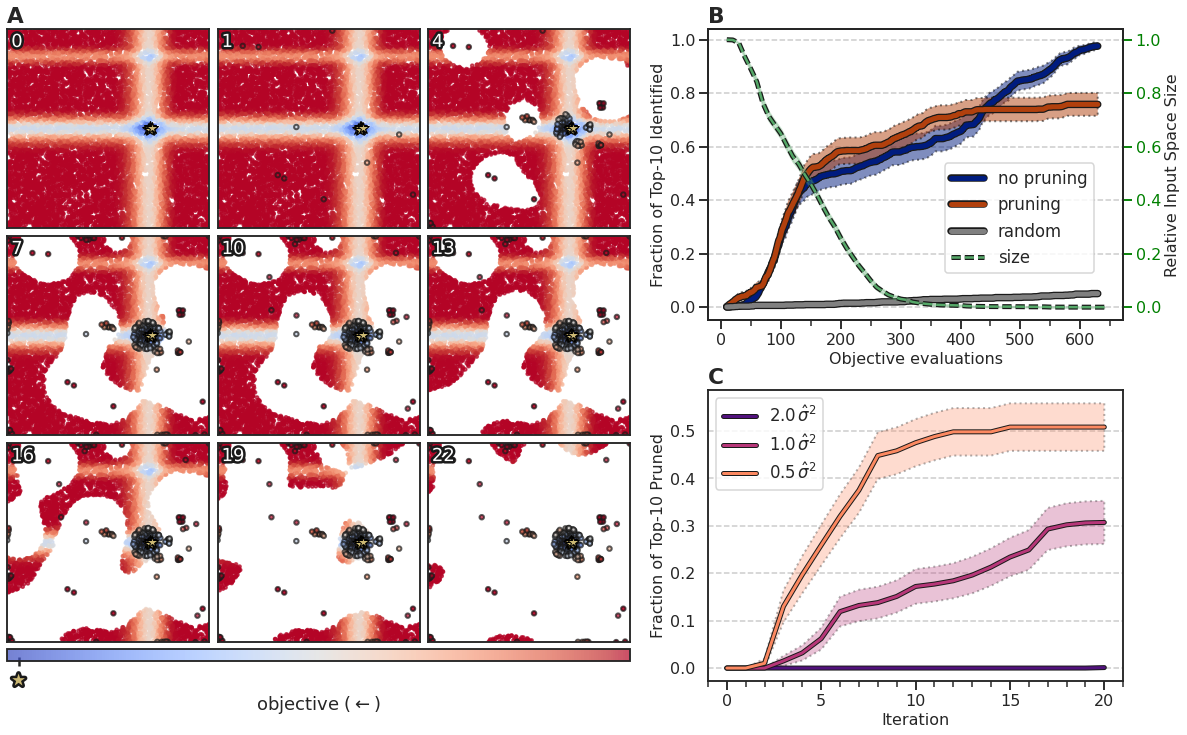

In [44]:
fig = plt.figure(figsize=(5*4, 3*4), constrained_layout=False)

gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.15)

gs0 = gs[0].subgridspec(3, 3, wspace=0.04, hspace=0.04)
gs1 = gs[1].subgridspec(2, 1, hspace=0.24)

#----------------------------------------- Panel A -----------------------------------------#

npzdir = Path('/home/degraff/active-projects/boip/runs/all-objs/michalewicz')
obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42)

n = 10
q = 10
k = 10

xmin, ymin = choices.min(0)[0].numpy()
xmax, ymax = choices.max(0)[0].numpy()

y_all = -obj(choices).numpy()
hit_idxs = np.argpartition(y_all, k)[:k]
hits = choices[hit_idxs].numpy()
zmin, zmax = y_all.min(), y_all.max()

REP = 0
X = np.load(f"{npzdir}/X.npz")["PRUNE"][REP]
Y = -np.load(f"{npzdir}/Y.npz")["PRUNE"][REP]
H = np.load(f"{npzdir}/H.npz")["PRUNE"][REP]

axs = []
it = 0
for a in range(3):
    for b in range(3):
        ax = fig.add_subplot(gs0[a, b])

        mask = prune(choices, H[:,1], it)

        if it == 0:
            sc = plot_surface_discrete(ax, choices[mask], y_all[mask], zmin, zmax, hits, title=it)
            it +=1
        else:
            plot_surface_discrete(ax, choices[mask], y_all[mask], zmin, zmax, hits, title=it)
            plot_acquired_points(ax, X[:q*4*(it-1) + n], Y[:q*4*(it-1) + n], zmin, zmax)
            it +=3
            
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        axs.append(ax)

cbar = fig.colorbar(
    sc, ax=axs, location="bottom", aspect=50, fraction=0.05, pad=0.01,
    ticks=[y_all[hit_idxs].max()], label=r"objective ($\leftarrow$)"
)
cbar.ax.set_xticklabels(
    [r"$\bigstar$"], color="y"
)[0].set_path_effects([pe.withStroke(linewidth=5, foreground="k")])
cbar.ax.tick_params("x", direction="inout", pad=6, width=2.5, grid_alpha=0.5)

axs[0].set_title("A", loc="left", size="large", weight="bold")

#----------------------------------------- Panel B -----------------------------------------#

ax = fig.add_subplot(gs1[0])

sns.set_palette(sns.color_palette("dark"))

npzdir = Path('/home/degraff/active-projects/boip/runs/all-objs/michalewicz')
obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42)

n = 10
k = 10
q = 10
T = 200

X_npz = np.load(f"{npzdir}/X.npz")
Y_npz = np.load(f"{npzdir}/Y.npz")
Y_full = Y_npz["FULL"]
Y_prune = Y_npz["PRUNE"]
H = np.load(f"{npzdir}/H.npz")["PRUNE"]

y_all = -obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, k)[:k]
optimal_choices = choices[optimal_idxs]
optima = -y_all[optimal_idxs]

handles = plot_IR(ax, Y_full, Y_prune, n, optima, obj, choices)

ax_twin = ax.twinx()
handles.append(plot_size_H(ax_twin, H, q, Y_prune.shape[1] // q))

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)

ax.tick_params(axis="both", labelsize=16)
ax_twin.tick_params(axis="y", colors='green', labelsize=16)
ax.set_xlabel("Objective evaluations", fontsize=16)
ax.set_ylabel("Fraction of Top-10 Identified", fontsize=16)
ax_twin.set_ylabel("Relative Input Space Size", fontsize=16)

ax_twin.set_ylim(ax.get_ylim())
ax.grid(True, axis="y", ls="--")

ax.legend(
    handles=handles, bbox_transform=ax.transAxes, bbox_to_anchor=[0.75, 0.35], loc="center"
)

ax.set_title("B", loc="left", size="large", weight="bold")

#----------------------------------------- Panel C -----------------------------------------#

ax = fig.add_subplot(gs1[1])

N = 10000
ds = 42
k = 10
T = 20
t = np.arange(T+1)

runs_dir = Path.home() / "active-projects/boip/runs/michalewicz-alpha"
npzdirs = list(runs_dir.iterdir())

obj = boip.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, N, ds) 

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]

palette = sns.color_palette("magma", len(npzdirs))
for npzdir, c in zip(npzdirs, palette):
    H = np.load(npzdir / "H.npz")["PRUNE"]

    gamma = float(npzdir.name)
    label=rf"${gamma}\,\hat\sigma^2$"
    
    F_nr = f_hits_pruned(H[:,:,1], optimal_idxs, T)
    F_nr_mean = F_nr.mean(0)
    F_nr_sem = stats.sem(F_nr, 0)

    ax.plot(
        t, F_nr_mean, color=c, lw=3,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()], label=label
    )
    ax.fill_between(
        t, F_nr_mean - F_nr_sem, F_nr_mean + F_nr_sem,
        color=c, dashes=":", lw=2, ec="black", alpha=0.3
    )

ax.legend()

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)
ax.grid(axis="y", ls="--")

ax.set_ylabel("Fraction of Top-10 Pruned", fontsize=16)
ax.set_xlabel("Iteration", fontsize=16)
ax.tick_params(axis="both", labelsize=16)

ax.set_title("C", loc="left", size="large", weight="bold")

In [25]:
fig.savefig("../figures/michalewicz-figure.pdf", dpi=400, bbox_inches="tight", pad_inches=0.1)

In [26]:
fig.savefig("../figures/michalewicz-figure.png", dpi=400, bbox_inches="tight", pad_inches=0.1)

## Regret and Surface Plots

[back to top](#table-of-contents)

The cell below will make the supplementary figure containing the contour plot and performance for each objective function that you've run. the `npzdirs` variable is a list of directories containing the collated results for each objective function. **NOTE:** Each directory name must be *exactly* the objective function that it corresponds to

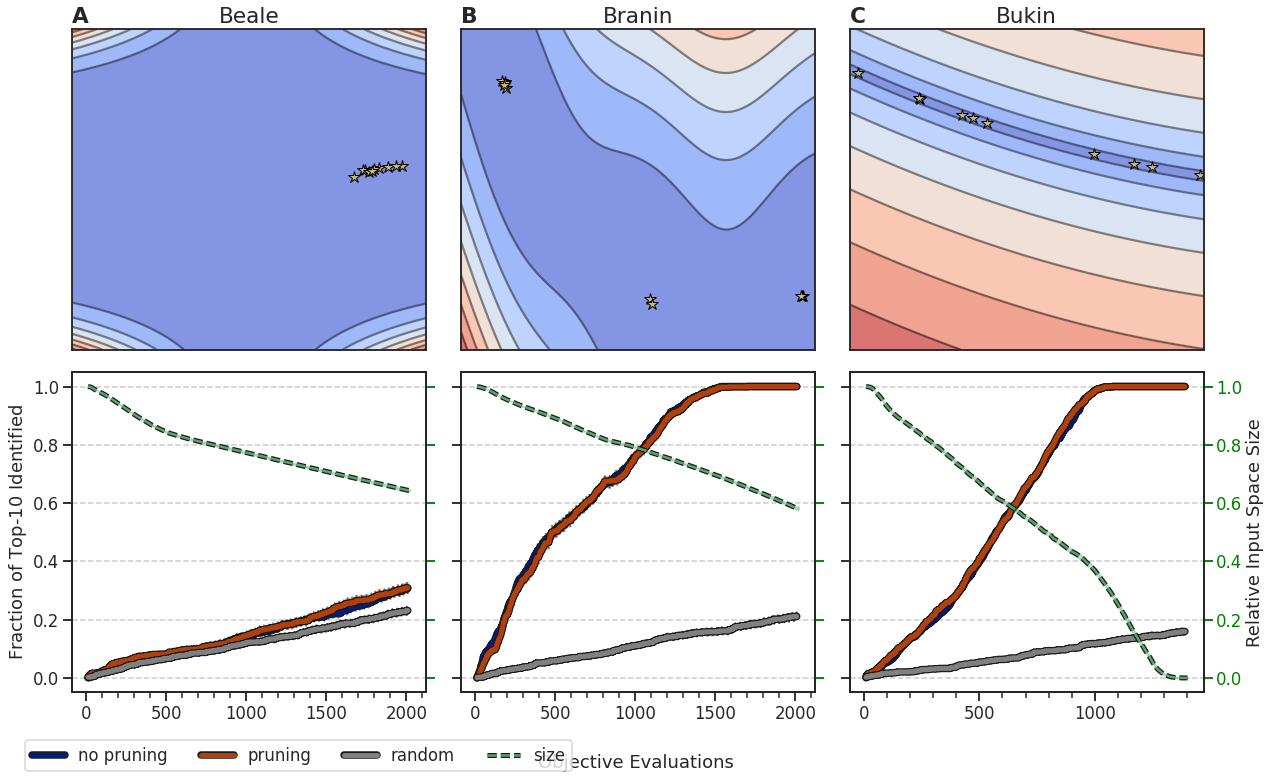

In [61]:
npzdirs = [
    Path.home() / "active-projects/boip/runs/all-objs/beale",
    Path.home() / "active-projects/boip/runs/all-objs/branin",
    Path.home() / "active-projects/boip/runs/all-objs/bukin",
    # Path.home() / "active-projects/boip/runs/all-objs/drop-wave",
    # Path.home() / "active-projects/boip/runs/all-objs/michalewicz",
    # Path.home() / "active-projects/boip/runs/all-objs/levy",
    # Path.home() / "active-projects/boip/runs/all-objs/camel"
]
objs = [boip.objectives.build_objective(p.stem) for p in npzdirs]

n = 10
k = 10
q = 10
T = 200

sns.set_palette(sns.color_palette("dark"))
fig, axs = plt.subplots(2, len(objs), figsize=(6 * len(objs), 11))

axs_2 = []
for i, (obj, npzdir, label) in enumerate(zip(objs, npzdirs, string.ascii_uppercase)):
    choices = boip.objectives.discretize(obj, 10000, 42)

    X_npz = np.load(f"{npzdir}/X.npz")
    Y_npz = np.load(f"{npzdir}/Y.npz")
    Y_full = Y_npz["FULL"]
    Y_prune = Y_npz["PRUNE"]
    H = np.load(f"{npzdir}/H.npz")["PRUNE"]

    y_all = obj(choices).numpy()
    optimal_idxs = np.argpartition(y_all, -k)[-k:]
    optimal_choices = choices[optimal_idxs]
    optima = y_all[optimal_idxs]

    plot_surface(axs[0][i], obj, optimal_choices)

    ax1 = axs[1][i]
    handles = plot_IR(ax1, Y_full, Y_prune, n, optima, obj, choices)

    ax2 = ax1.twinx()
    handles.append(plot_size_H(ax2, H, q, Y_prune.shape[1] // q))
    axs_2.append(ax2)

    ax1.set_ylim(-0.05, 1.05)
    ax2.set_ylim(ax1.get_ylim())
    ax1.grid(True, axis="y", ls="--")

    ax1.xaxis.set_major_locator(MultipleLocator(500))
    ax1.xaxis.set_minor_locator(MultipleLocator(100))
    ax1.tick_params(axis="x", which="both", direction="out", bottom=True)

    axs[0][i].set_title(label, loc="left", weight="bold", fontsize="large")

for ax1 in axs[1][1:]:
    ax1.sharey(axs[1][0])
    ax1.tick_params('y', labelleft=False)

for ax2 in axs_2[:-1]:
    ax2.sharey(axs_2[-1])
    ax2.tick_params('y', labelright=False, colors='green')

axs_2[-1].tick_params('y', colors='green')

fig.legend(
    handles=handles,
    ncol=4,
    bbox_to_anchor=(0.24, 0),
    loc="lower center",
)

fig.supxlabel("Objective Evaluations", fontsize=18)
axs[1][0].set_ylabel(r"Fraction of Top-$10$ Identified")
axs_2[-1].set_ylabel("Relative Input Space Size")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.07)

In [8]:
fig.savefig("../figures/all-objs-regret+surface.pdf", dpi=400, bbox_inches="tight")
fig.savefig("../figures/all-objs-regret+surface.png", dpi=400, bbox_inches="tight")

### Extra regret plots

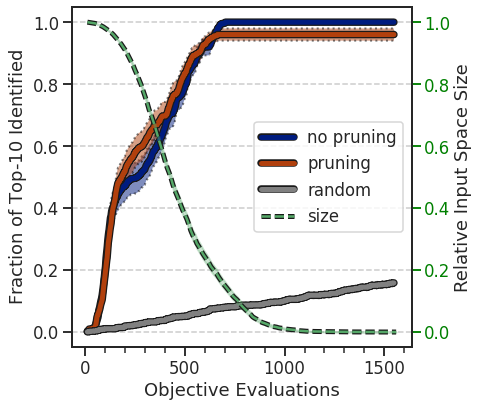

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.set_palette(sns.color_palette("dark"))

n = 10
k = 10
q = 10
T = 200

npzdir = Path.home() / "active-projects/boip/runs/michalewicz-obs"
obj = boip.objectives.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, 10000, 42)

X_npz = np.load(f"{npzdir}/X.npz")
Y_npz = np.load(f"{npzdir}/Y.npz")
Y_full = Y_npz["FULL"]
Y_prune = Y_npz["PRUNE"]
H = np.load(f"{npzdir}/H.npz")["PRUNE"]

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]
optimal_choices = choices[optimal_idxs]
optima = y_all[optimal_idxs]

handles = plot_IR(ax, Y_full, Y_prune, n, optima, obj, choices)

ax_twin = ax.twinx()
handles.append(plot_size_H(ax_twin, H, q, Y_prune.shape[1] // q))

ax_twin.set_ylim(ax.get_ylim())
ax.grid(True, axis="y", ls="--")

ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)

ax_twin.tick_params('y', colors='green')

ax.legend(handles=handles)

ax.set_xlabel("Objective Evaluations")
ax.set_ylabel(r"Fraction of Top-$10$ Identified")
ax_twin.set_ylabel("Relative Input Space Size")

fig.tight_layout()

In [12]:
fig.savefig("../figures/michalewicz-obs-regret.pdf", bbox_inches="tight")

### Individual traces plots

/tmp/degraff/ipykernel_3491152/3788902549.py:28: RuntimeWarning: invalid value encountered in true_divide
  return Y_star / len(optima)


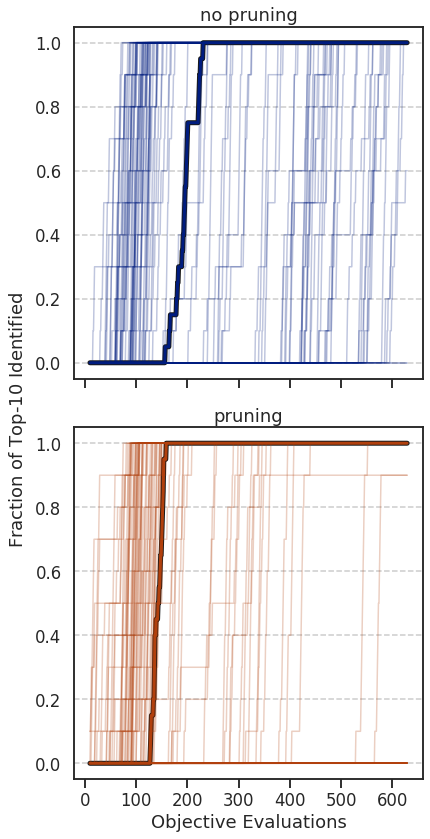

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(6.5, 12), sharey=True, sharex=True)
sns.set_palette(sns.color_palette("dark"))

n = 10
k = 10
q = 10
T = 200

npzdir = Path.home() / "active-projects/boip/runs/all-objs/michalewicz"
obj = boip.objectives.build_objective("michalewicz")

choices = boip.objectives.discretize(obj, 10000, 42)
Y_npz = np.load(f"{npzdir}/Y.npz")
Y_f = Y_npz["FULL"]
Y_p = Y_npz["PRUNE"]
Ys = (Y_f, Y_p)

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]
optimal_choices = choices[optimal_idxs]
optima = y_all[optimal_idxs]

x = np.arange(Y_p.shape[1])[n:]

for ax, Y, c in zip(axs, Ys, sns.color_palette("dark", len(Ys))):
    R = immediate_regret(Y, optima)[:, n : n + len(x)]

    ax.plot(
        x,
        np.median(R, 0),
        color=c,
        lw=3,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()],
    )
    for r in R:
        ax.plot(
            x,
            r,
            color=c,
            lw=1.5,
            alpha=0.25
        )

    ax.grid(True, axis="y", ls="--")
    ax.tick_params(axis="x", which="both", direction="out", bottom=True)

ax.xaxis.set_major_locator(MultipleLocator(100))

axs[0].set_title("no pruning")
axs[1].set_title("pruning")

fig.supylabel(r"Fraction of Top-$10$ Identified", x=0.07, fontsize=18)
ax.set_xlabel("Objective Evaluations", y=-0.05, fontsize=18)

fig.tight_layout()

## Gamma sweep

[back to top](#table-of-contents)

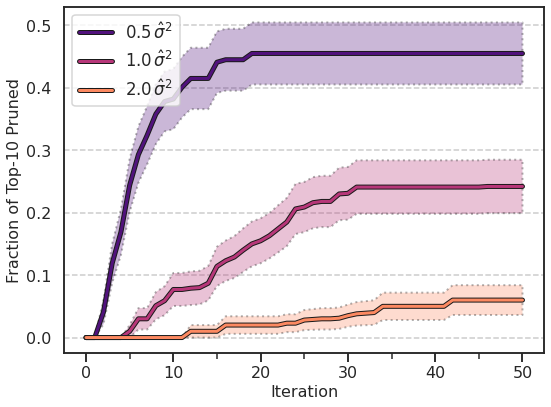

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

N = 10000
ds = 42
k = 10
T = 50
t = np.arange(T+1)

runs_dir = Path.home() / "active-projects/boip/runs/michalewicz-gamma"
# runs_dir = Path.home() / "active-projects/boip/runs/michalewicz-alpha"

npzdirs = sorted(runs_dir.iterdir(), key=lambda d: float(d.name))

obj = boip.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, N, ds) 

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]

palette = sns.color_palette("magma", len(npzdirs))
for npzdir, c in zip(npzdirs, palette):
    H = np.load(npzdir / "H.npz")["PRUNE"]

    gamma = float(npzdir.name)
    label=rf"${gamma}\,\hat\sigma^2$"
    
    F_nr = f_hits_pruned(H[:,:,1], optimal_idxs, T)
    F_nr_mean = F_nr.mean(0)
    F_nr_sem = stats.sem(F_nr, 0)

    ax.plot(
        t, F_nr_mean, color=c, lw=3,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()], label=label
    )
    ax.fill_between(
        t, F_nr_mean - F_nr_sem, F_nr_mean + F_nr_sem,
        color=c, dashes=":", lw=2, ec="black", alpha=0.3
    )

ax.legend()

# ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)
ax.grid(axis="y", ls="--")

ax.set_ylabel("Fraction of Top-10 Pruned", fontsize=16)
ax.set_xlabel("Iteration", fontsize=16)
ax.tick_params(axis="both", labelsize=16)

fig.tight_layout()

In [56]:
fig.savefig("../figures/michal-gamma-pruning.pdf", dpi=400, bbox_inches="tight")

### Gamma sweep performance

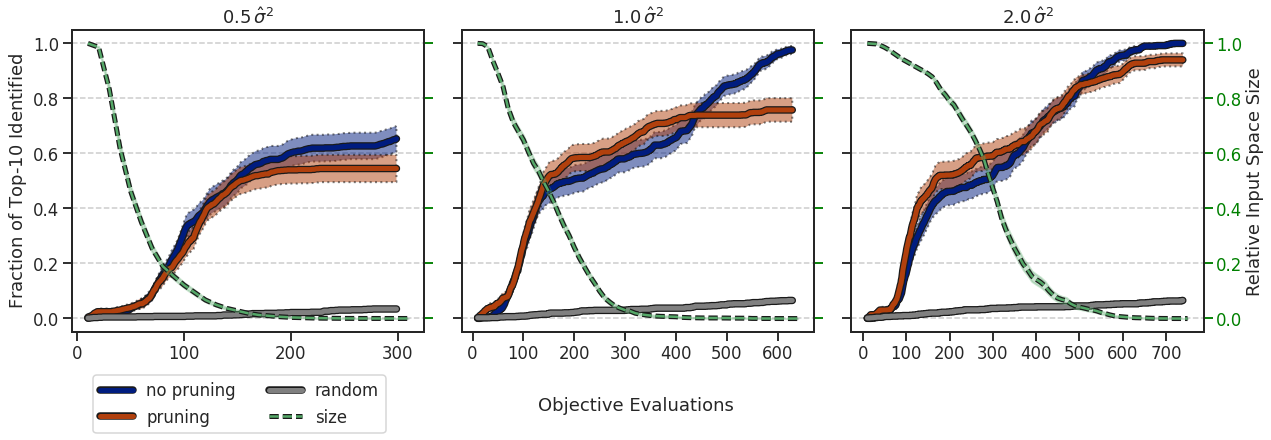

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 6), sharey=True)

N = 10000
ds = 42
k = 10
n = 10
q = 10

runs_dir = Path.home() / "active-projects/boip/runs/michalewicz-gamma"
npzdirs = sorted(runs_dir.iterdir(), key=lambda d: float(d.name))

palette = sns.color_palette(None, len(npzdirs))
obj = boip.build_objective("michalewicz")
choices = boip.objectives.discretize(obj, N, ds) 

y_all = obj(choices).numpy()
optimal_idxs = np.argpartition(y_all, -k)[-k:]
optimal_choices = choices[optimal_idxs]
optima = y_all[optimal_idxs]

axs_2 = []
for ax, npzdir in zip(axs, npzdirs):
    gamma = float(npzdir.name)
    title=rf"${gamma}\,\hat\sigma^2$"
    ax.set_title(title)

    Y_npz = np.load(f"{npzdir}/Y.npz")
    H = np.load(f"{npzdir}/H.npz")["PRUNE"]

    y_all = obj(choices).numpy()
    optimal_idxs = np.argpartition(y_all, -k)[-k:]
    optimal_choices = choices[optimal_idxs]
    optima = y_all[optimal_idxs]

    handles = plot_IR(ax, Y_npz["FULL"], Y_npz["PRUNE"], n, optima, obj, choices)

    ax2 = ax.twinx()
    handles.append(plot_size_H(ax2, H, q, H.max()+1))
    axs_2.append(ax2)

    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.tick_params(axis="x", which="both", direction="out", bottom=True)
    ax.grid(True, axis="y", ls="--")
    ax2.set_ylim(ax.get_ylim())

for ax2 in axs_2[:-1]:
    ax2.sharey(axs_2[-1])
    ax2.tick_params('y', labelright=False, colors='green')
axs_2[-1].tick_params('y', colors='green')

fig.legend(
    handles=handles,
    ncol=2,
    bbox_to_anchor=(0.075, -0.05),
    loc="lower left",
)

axs[0].set_ylabel(r"Fraction of Top-$10$ Identified")
axs_2[-1].set_ylabel("Relative Input Space Size")
fig.supxlabel("Objective Evaluations", fontsize=18)

fig.tight_layout()

fig.savefig("../figures/michal-gamma-performance.pdf", dpi=200, bbox_inches="tight")

### False pruning of hits plots

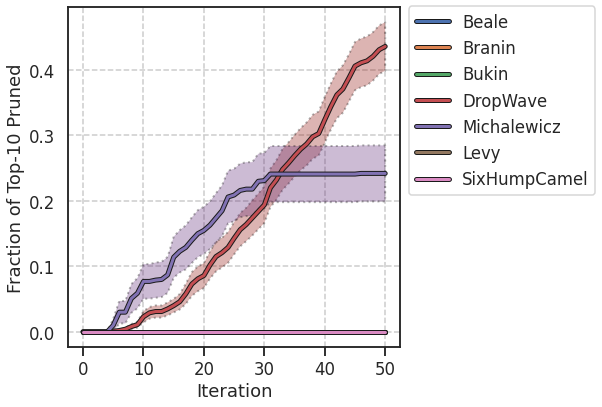

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

N = 10000
ds = 42
k = 10
T = 50
t = np.arange(T+1)

npzdirs = [
    Path.home() / "active-projects/boip/runs/all-objs/beale",
    Path.home() / "active-projects/boip/runs/all-objs/branin",
    Path.home() / "active-projects/boip/runs/all-objs/bukin",
    Path.home() / "active-projects/boip/runs/all-objs/drop-wave",
    Path.home() / "active-projects/boip/runs/all-objs/michalewicz",
    Path.home() / "active-projects/boip/runs/all-objs/levy",
    Path.home() / "active-projects/boip/runs/all-objs/camel"
]
objs = [boip.objectives.build_objective(p.stem) for p in npzdirs]
palette = sns.color_palette("deep", len(npzdirs))

for obj, npzdir, c in zip(objs, npzdirs, palette):
    choices = boip.objectives.discretize(obj, N, ds) 
    npz = np.load(npzdir / "H.npz")

    y_all = obj(choices).numpy()
    hit_idxs = np.argpartition(y_all, -k)[-k:]

    H = npz["PRUNE"]
    FNR_obs = f_hits_pruned(H[:,:,1], hit_idxs, T)
    FNR_obs_mu = FNR_obs.mean(0)
    FNR_obs_se = stats.sem(FNR_obs, 0)

    ax.plot(
        t, FNR_obs_mu, label=str(obj)[:-2], lw=3, c=c,
        path_effects=[pe.Stroke(linewidth=5, foreground="k"), pe.Normal()]
    )
    ax.fill_between(
        t, FNR_obs_mu - FNR_obs_se, FNR_obs_mu + FNR_obs_se, alpha=0.3,
        dashes=":", lw=2, ec="black"
    )

ax.set_ylabel("Fraction of Top-10 Pruned")
ax.set_xlabel("Iteration")
# ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.tick_params(axis="x", which="both", direction="out", bottom=True)
ax.grid(axis="both", ls="--")

fig.tight_layout()

fig.legend(bbox_to_anchor=(1.425, 0.975))

## Design Space Pruning

[back to top](#table-of-contents)

run the cell below to generate individual images corresponding to the design space at the given iteration. You can later combine these images into a GIF for a nice visualization of the pruning process! There are 3 custom values to define: `START`, `STOP`, and `STEP`, which define the range of iterations for which you'd like to generate the images. Adjust `npzdir`, `REP`, and the figure save path as necessary to suit your needs!

In [ ]:
START = 0
STOP = 31
STEP = 2

npzdir = Path.home() / "active-projects/boip/runs/10000-10+200x10-multi/michalewicz"

obj = boip.objectives.build_objective(npzdir.stem)
choices = boip.objectives.discretize(obj, 10000, 42) 

n = 10
q = 10
k = 10

y_all = -obj(choices).numpy()
hit_idxs = np.argpartition(y_all, k)[:k]
hits = choices[hit_idxs]

choices = choices.numpy()
xmin, ymin = choices.min(0)
xmax, ymax = choices.max(0)

REP = 2
X = np.load(f"{npzdir}/X.npz")["PRUNE"][REP]
Y = -np.load(f"{npzdir}/Y.npz")["PRUNE"][REP]
H = np.load(f"{npzdir}/H.npz")["PRUNE"][REP]

for i in range(START, STOP, STEP):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    it = i
    mask = prune(choices, H[:,1], it)

    plot_surface_discrete(ax, choices[mask], y_all[mask], hits, title=it)
    if it > 0:
        plot_acquired_points(ax, X[:q*4*(it-1) + n], Y[:q*4*(it-1) + n])

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    fig.savefig(
        f"../figures/michalewicz-gif/iter_{i}.png", dpi=200, bbox_inches='tight', pad_inches=0.01
    )